In [2]:
import pandas as pd
import numpy as np
from meteostat import Point, Monthly
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
# Download temperature data for Missoula
start = datetime(1999, 10, 1)
end = datetime(2023, 9, 30)
mso = Point(46.86890938888096, -113.99148295276562, 1100)
data = Monthly(mso, start, end)
df_temp = data.fetch()['tmax']
df_temp.to_csv('../data/mso_avg_monthly_tmax.csv')

# Bring in population data and resample to monthly
df_pop = pd.read_csv('../data/mso_pop_year_full.csv', index_col=0)
df_pop.index = pd.to_datetime(df_pop.index, format="%Y")
df_pop = df_pop['population'].resample('MS').mean().interpolate()[start:end]

# Bring City pumping rates
df_dem = pd.read_csv('../data/mso_monthly_pumping_rates.csv')
df_dem['yrmo'] = pd.to_datetime(df_dem['yrmo'], format="%b %Y")
df_dem.set_index('yrmo', inplace=True)
df_dem = df_dem['vol_Mg'][start:end]

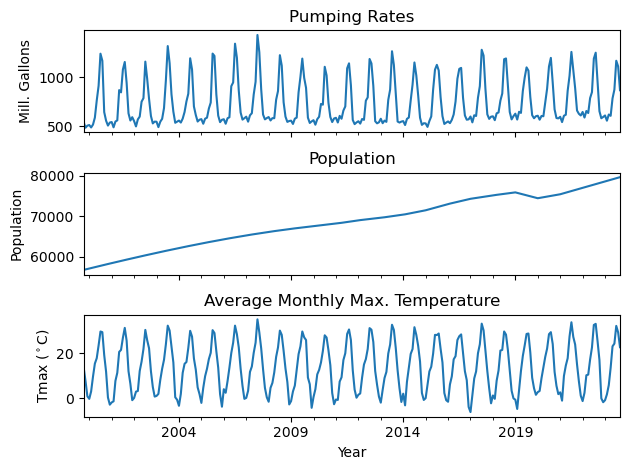

In [4]:
fig, ax = plt.subplots(3, 1, sharex=True)
df_dem.plot(ax=ax[0])
df_pop.plot(ax=ax[1])
df_temp.plot(ax=ax[2])
ax[0].set_title('Pumping Rates')
ax[0].set_ylabel('Mill. Gallons')
ax[1].set_title('Population')
ax[1].set_ylabel('Population')
ax[2].set_title('Average Monthly Max. Temperature')
ax[2].set_ylabel('Tmax ($^\circ$C)')
plt.xlabel('Year')
plt.tight_layout()

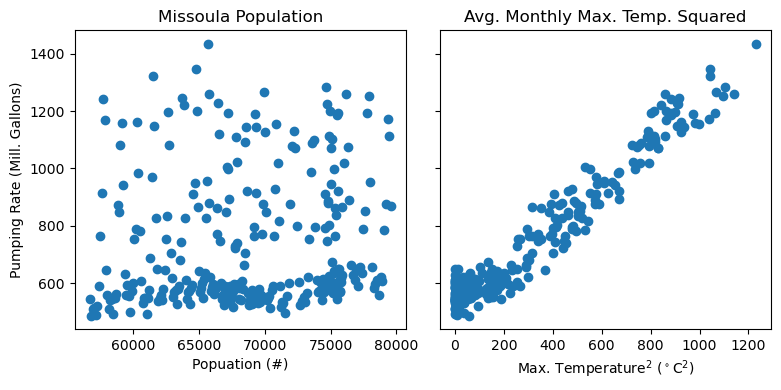

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
ax[0].scatter(df_pop.values, df_dem.values)
ax[0].set_title('Missoula Population')
ax[0].set_xlabel('Popuation (#)')
ax[1].scatter(df_temp.values**2, df_dem.values)
ax[1].set_title('Avg. Monthly Max. Temp. Squared')
ax[1].set_xlabel('Max. Temperature$^2$ ($^\circ$C$^2$)')
ax[0].set_ylabel('Pumping Rate (Mill. Gallons)')
plt.tight_layout()

### OLS model

In [9]:
x = df_temp.values**2
#x = np.column_stack((df_pop.values, df_temp.values**2))
x = sm.add_constant(x)
y = df_dem.values

In [10]:
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     5217.
Date:                Wed, 21 Aug 2024   Prob (F-statistic):          1.09e-185
Time:                        15:24:22   Log-Likelihood:                -1548.1
No. Observations:                 288   AIC:                             3100.
Df Residuals:                     286   BIC:                             3107.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        531.1013      4.226    125.686      0.000     522.784     539.419
x1             0.6838      0.009     72.231      0.000       0.665       0.702
==============================================================================
Omnibus:                        0.605   Durbin-Watson:                   1.299
Prob(Omnibus):                  0.739   Jarque-Bera (JB):                0.710
Skew:                           0.010   Prob(JB):                        0.701
Kurtosis:                       2.758   Cond. No.                         610.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

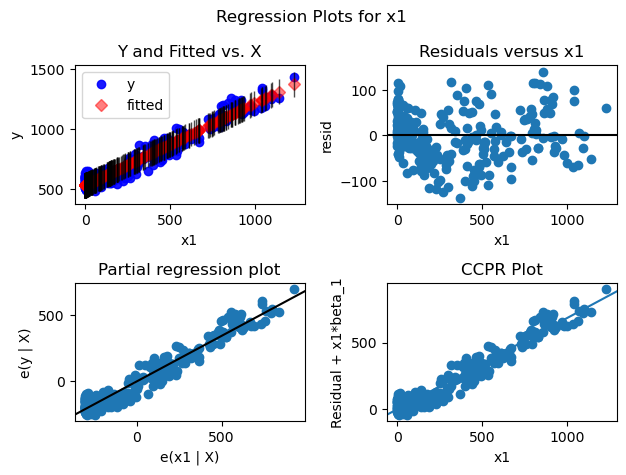

In [53]:
fig = sm.graphics.plot_regress_exog(model, 'x1')
fig.tight_layout()

In [54]:
intercept = model.params[0]
slope = model.params[1]
rsquared = model.rsquared
x_values = np.linspace(min(x[:, 1]), max(x[:, 1]), 100)
y_values = slope * x_values + intercept

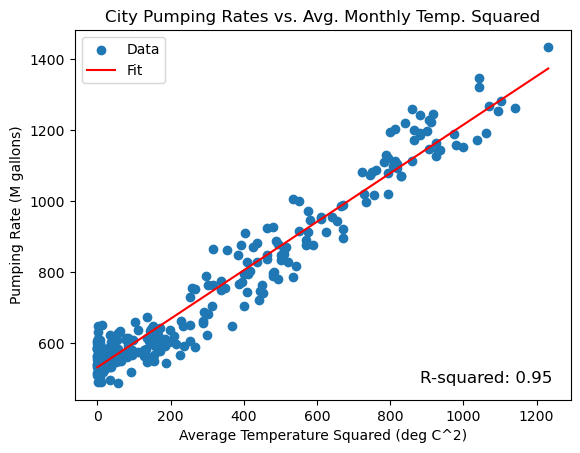

In [57]:
plt.scatter(x[:, 1], y, label='Data')
plt.plot(x_values, y_values, color='red', label='Fit')
plt.xlabel('Average Temperature Squared (deg C^2)')
plt.ylabel('Pumping Rate (M gallons)')
plt.title('City Pumping Rates vs. Avg. Monthly Temp. Squared')

text_x = max(x[:, 1]) - 350  # X-coordinate for the text
text_y = min(y)  # Y-coordinate for the text
plt.text(text_x, text_y, f'R-squared: {rsquared:.2f}', fontsize=12)

plt.legend()
plt.show()